# Behavior Cloning

## Objective: Fly balloon to a target location.

1.Imitation learning is a paradigm where an agent learns to mimic an **expert's behavior** instead of learning purely from trial-and-error rewards (e.g., reinforcement learning).

- The simplest common approach is called "**behavior cloning**" (BC). It treats the expert's demonstrations as training data samples; train a policy using the expert's input(state) and output(action) pairs via supervised learning.

## For Colab users

In [ ]:
# Clone the repository
import os

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print("✅ Found:", git_path)
    %cd balloon-outreach/
else:
    print("❌ Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

❌ Not found: /content/balloon-outreach
Cloning into 'balloon-outreach'...
remote: Enumerating objects: 1377, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 1377 (delta 94), reused 91 (delta 82), pack-reused 1246 (from 3)
Receiving objects: 100% (1377/1377), 63.69 MiB | 18.34 MiB/s, done.
Resolving deltas: 100% (856/856), done.
/content/balloon-outreach
Already on 'main'
Your branch is up to date with 'origin/main'.


In [ ]:
import sys
sys.path.append('/content/balloon-outreach/')

# Install required packages
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.0 MB/s eta 0:00:00
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=e56417ec3f24079559ac3fa1c09409aa64c2bd2b066f9a1ca7340f6d1cfafe55
  Stored in directory: /root/.cache/pip/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField

In [4]:
from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Check existence
if os.path.exists('/content/drive/My Drive/era5_data.nc'):
    print("✅ Found:", '/content/drive/My Drive/era5_data.nc')
    datapath = '/content/drive/My Drive/era5_data.nc'

elif os.path.exists("/content/balloon-outreach/era5_data.nc"):
    print("✅ Found:", "/content/balloon-outreach/era5_data.nc")
    datapath = "/content/balloon-outreach/era5_data.nc"

else:
    print("❌ Not found")
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"


Mounted at /content/drive
✅ Found: /content/drive/My Drive/era5_data.nc


## Import packages

In [3]:
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction, MPPIAgent
from utils.learning_util import plot_expert_summary, plot_agent_summary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Setup Environment

In [4]:
ds          = xr.open_dataset(datapath, engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)
add_noise   = False

#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0

target_lat = 77.3
target_lon = -80.5
target_alt = 12.0

time_step = 120 #120 seconds
objective = 'target'

env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            add_noise=add_noise,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            objective=objective,
                            dt=time_step,
                            viz=False)

WindField initialized with noise disabled.


In [5]:
initial_state = env.reset()
print(initial_state) # 21-dimensional vector

# state = (latitude, longitude, altitude, volume/max_volume, sand/max_sand,
# vertical velocity, current_time, uv vectors in 7 different pressure levels)

[ 42.6        -76.5         10.           1.           1.
   0.           0.           2.68826294  -2.50693054  11.1584198
  -7.97099304  14.01635132  -5.00876465  27.14085999   3.41699524
  34.82033386  14.09255371  38.58664856   7.6340332   18.78843994
  -4.25058899]


## Define expert policy

In [6]:
# Parameters for MPPI agent

max_steps = int(1440/(time_step/60)) #1 day

num_samples=10
acc_bounds= (-0.1, 0.1)
noise_std = 0.1
num_iterations=1
temperature=10
horizon=10

In [7]:
expert = MPPIAgentWithCostFunction(target_lat=target_lat,
                                   target_lon=target_lon,
                                   target_alt=target_alt,
                                   num_samples=num_samples,
                                   acc_bounds= acc_bounds,
                                   noise_std=noise_std,
                                   num_iterations=num_iterations,
                                   temperature=temperature,
                                   horizon=horizon,
                                   visualize=False,
                                   objective=objective)

## Collect expert state-action pair

In [8]:
# Run an episode from an expert and collect its behavior

def run_expert_episode(
        env: BalloonERAEnvironment,
        agent:MPPIAgent,
        max_steps: int = 100,
        policy_name: str='expert'):
    """
    Run one episode with the given agent,
    collect state-action pair of the agent,
    and plot its trajectory in the given environment.
    """
    # Save state-action pairs from expert policy
    initial_states = []
    initial_actions = []

    state = env.reset()
    total_reward = 0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []
    for step in range(max_steps):
        # Get action from agent
        action = agent.select_action(state, env, step)

        # record state and expert action
        initial_states.append(state)
        initial_actions.append(action)

        # Take step
        state, reward, done, info = env.step(action)
        total_reward += reward

        actions.append(float(action[0]) if isinstance(action, np.ndarray) else float(action))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])
        # print(f"Step {step}: lat: {state[0]:.2f}, lon: {state[1]:.2f}, alt: {state[2]:.2f}")

        if done:
            print(f"\nEpisode terminated: {info}")
            break

    # Convert to arrays
    states_np = np.array(initial_states, dtype=np.float32)
    actions_np = np.array(initial_actions, dtype=np.float32)
    print(f"Collected {len(initial_states)} state-action pairs from expert.")

    # --- Combined 2x2 Summary Plot ---
    plot_fnm = plot_expert_summary(agent, trajectory, altitudes, actions, velocities, helium_mass, sands, policy_name, max_steps, time_step)

    return total_reward, states_np, actions_np, plot_fnm

In [9]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
expert_total_reward_list = []
expert_states_list = []
expert_actions_list = []
expert_plot_fnms_list = []
num_iter = 3
for i in range(num_iter):
    expert_total_reward, expert_states_np, expert_actions_np, fnm = run_expert_episode(env, expert, max_steps=max_steps, policy_name=f'expert_{i+1}')
    expert_total_reward_list.append(expert_total_reward)
    expert_states_list.append(expert_states_np)
    expert_actions_list.append(expert_actions_np)
    expert_plot_fnms_list.append(fnm)

Collected 720 state-action pairs from expert.
Initial position: [42.6, -76.5], Target position: [77.3, -80.5], End position: [77.1, -80.6], Distance: 11.703635446228343 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10
Collected 720 state-action pairs from expert.
Initial position: [42.6, -76.5], Target position: [77.3, -80.5], End position: [77.1, -80.6], Distance: 11.703635446228343 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10
Collected 720 state-action pairs from expert.
Initial position: [42.6, -76.5], Target position: [77.3, -80.5], End position: [77.1, -80.6], Distance: 11.703635446228343 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10


In [10]:
expert_plot_fnms_list

['figs/target/balloon_summary_expert_1_(77.3,-80.5)_(77.1,-80.6)_(10s,1it,10h,10t)_err_11.70km.png',
 'figs/target/balloon_summary_expert_2_(77.3,-80.5)_(77.1,-80.6)_(10s,1it,10h,10t)_err_11.70km.png',
 'figs/target/balloon_summary_expert_3_(77.3,-80.5)_(77.1,-80.6)_(10s,1it,10h,10t)_err_11.70km.png']

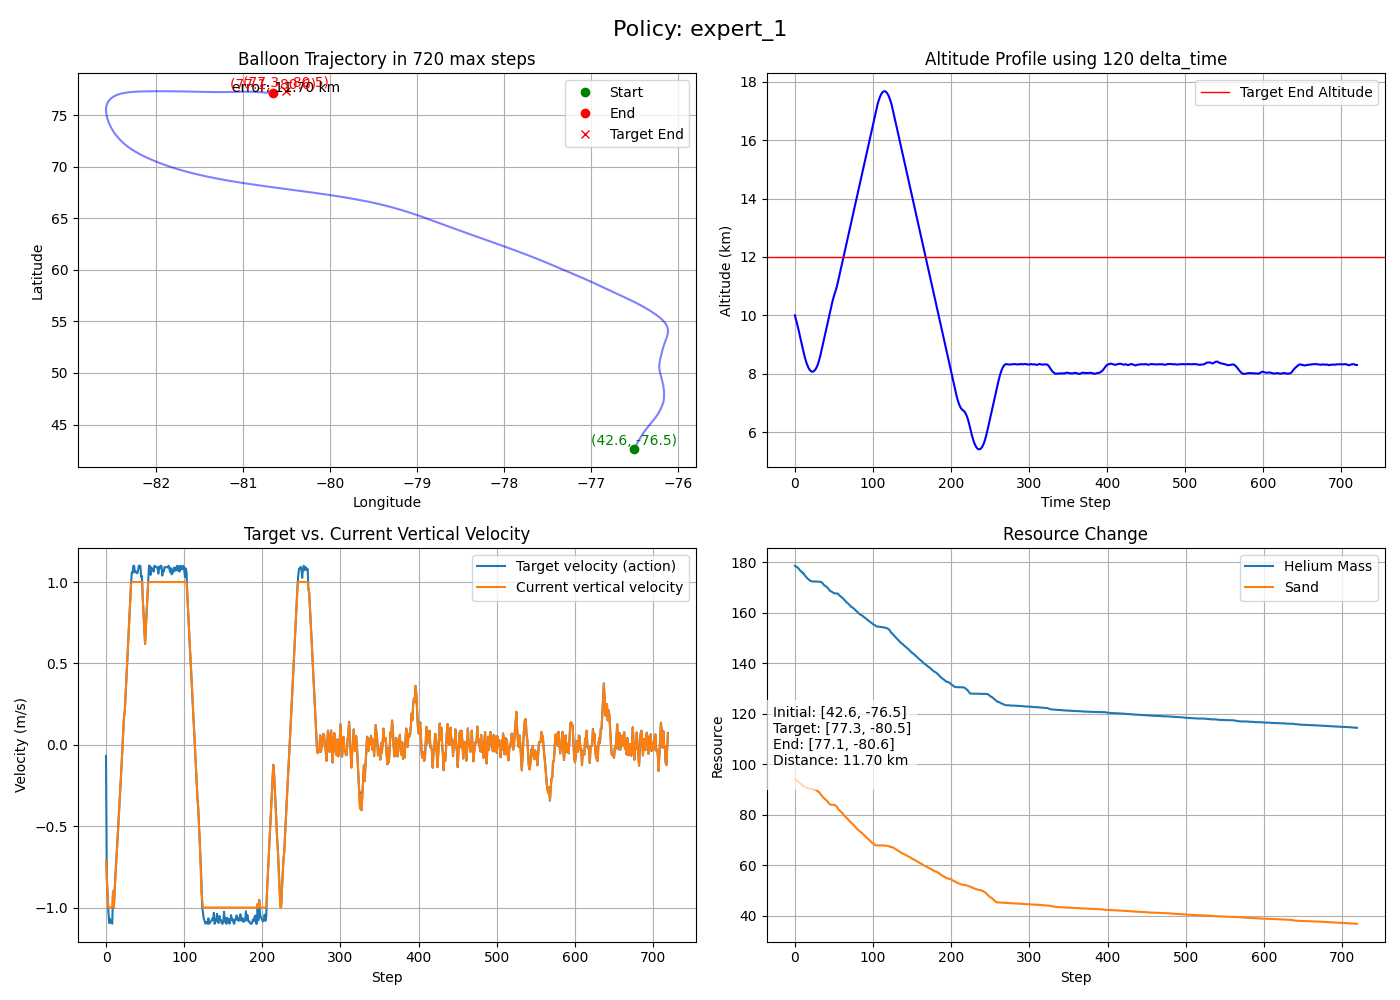

In [11]:
from IPython.display import Image, display
display(Image(filename=expert_plot_fnms_list[0]))

In [12]:
print(expert_total_reward_list)
expert_avg_total_reward = sum(expert_total_reward_list)/len(expert_total_reward_list)
print(f"Expert Trajectory reward in average: {expert_avg_total_reward:.2f}")

[-8202.109120611281, -8204.847995813378, -8213.452172781188]
Expert Trajectory reward in average: -8206.80


In [13]:
expert_states_np = np.concatenate(expert_states_list)
expert_actions_np = np.concatenate(expert_actions_list)

## Define our policy network

In [30]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=64, output_dim=1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.ln1 = nn.LayerNorm(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)

# Initialize policy network and optimizer
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

print(any(p.isnan().any().item() for p in policy.parameters()))

False


In [31]:
def evaluate_policy(env: BalloonERAEnvironment,
                    policy: nn.Module,
                    objective: str,
                    max_steps: int,
                    policy_name: str,
                    expert_avg_total_reward: float):
    policy.eval()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    state = env.reset()
    total_reward = 0.0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []

    for step in range(max_steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)      # shape (1, 21)
        assert not torch.isnan(state_tensor).any(), "NaNs in state!"

        action_pred = policy(state_tensor)                               # continuous action
        assert not torch.isnan(action_pred).any(), "NaNs in action prediction!"

        state, reward, done, info = env.step(action_pred.item())
        total_reward += reward

        actions.append(float(action_pred) if isinstance(action_pred, np.ndarray) else float(action_pred))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])

        if done:
            print(f"\nEpisode terminated: {info}")
            break
    print(f"Total reward obtained from current policy: {total_reward:.2f}")
    print(f"Expert policy reward - Current policy reward: {expert_avg_total_reward-total_reward:.2f}")

    # Plot summary (figs/target)
    plot_fnm = plot_agent_summary(
        trajectory=trajectory,
        altitudes=altitudes,
        actions=actions,
        velocities=velocities,
        helium_mass=helium_mass,
        sands=sands,
        policy_name=policy_name,
        max_steps=max_steps,
        dt=env.dt,
        objective=objective,
        target_lon=env.target_lon,
        target_lat=env.target_lat,
        target_alt=env.target_alt
        )

    return total_reward, plot_fnm


In [32]:
ds          = xr.open_dataset(datapath, engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)
add_noise   = False

#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0

target_lat = 77.3
target_lon = -80.5
target_alt = 12.0

time_step = 120 #120 seconds
objective = 'target'

env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            add_noise=add_noise,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            objective=objective,
                            dt=time_step,
                            viz=False)

total_reward, random_fnm = evaluate_policy(env, policy, objective, max_steps=max_steps, policy_name='random_policy', expert_avg_total_reward=expert_avg_total_reward)

WindField initialized with noise disabled.
→ policy is in evaluation mode

Episode terminated: No sand left
Total reward obtained from current policy: -14271.90
Expert policy reward - Current policy reward: 6065.10
Initial position: [42.6, -76.5], Target position: [77.3, -80.5], End position: [51.2, -77.4], Distance: 645.9042307971674 km


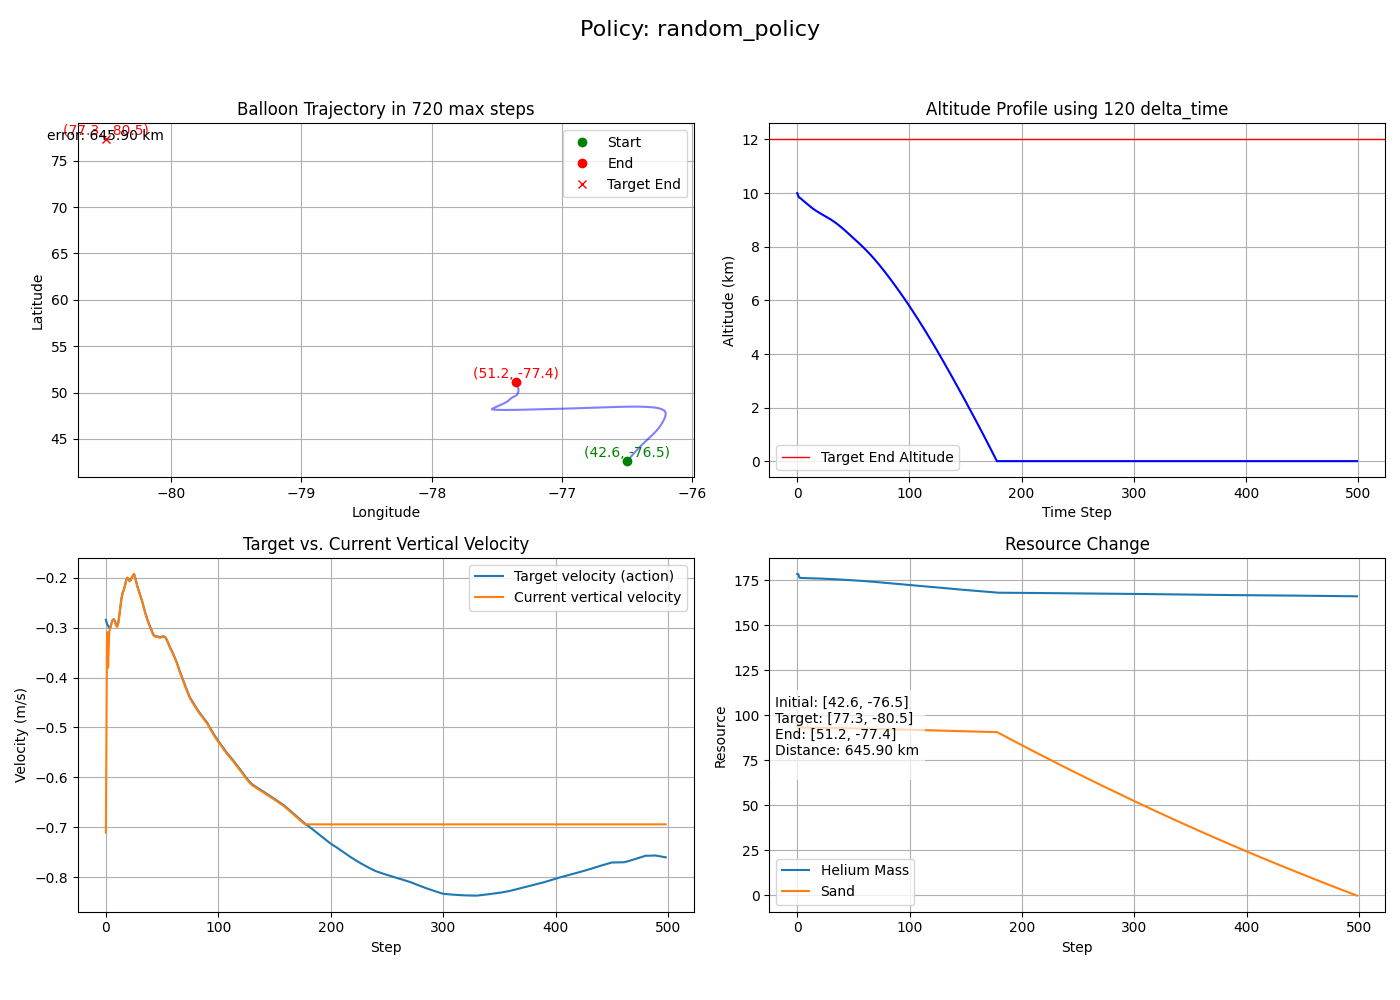

In [33]:
display(Image(filename=random_fnm))

## Behavior Cloning (Supervised Learning)

In [34]:
# === Initial Dataset & DataLoader Construction ===

# Convert to tensors
states_tensor = torch.from_numpy(expert_states_np).float()               # shape (N, 21)
actions_tensor = torch.from_numpy(expert_actions_np).float()             # shape (N, 1)

# Construct TensorDataset and DataLoader
dataset = TensorDataset(states_tensor, actions_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [35]:
# === Training Function Using Loader ===
def train_one_epoch(loader, policy, optimizer, loss_fn):
    policy.train()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    total_loss = 0.0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = policy(x_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

→ policy is in training mode
Epoch 1/5 — Avg Loss: 0.233630 

→ policy is in training mode
Epoch 2/5 — Avg Loss: 0.104326 

→ policy is in training mode
Epoch 3/5 — Avg Loss: 0.054597 

→ policy is in training mode
Epoch 4/5 — Avg Loss: 0.029173 

→ policy is in training mode
Epoch 5/5 — Avg Loss: 0.028580 



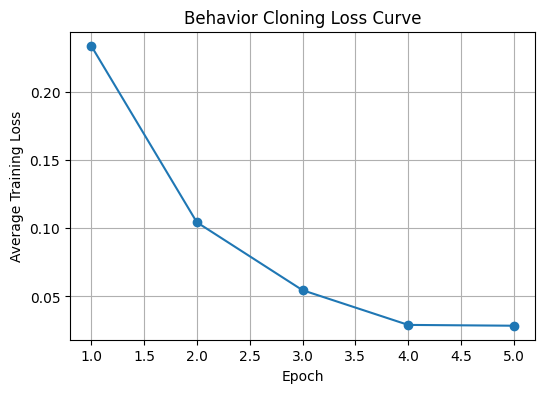

In [36]:
losses = []
for epoch in range(5):
    avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/5 — Avg Loss: {avg_loss:.6f} \n")

# plot the loss curve from behavior cloning
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Behavior Cloning Loss Curve')
plt.grid(True)
plt.show()

In [39]:
ds          = xr.open_dataset(datapath, engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)
add_noise   = False

#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0

target_lat = 77.3
target_lon = -80.5
target_alt = 12.0

time_step = 120 #120 seconds
objective = 'target'

env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            add_noise=add_noise,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            objective=objective,
                            dt=time_step,
                            viz=False)

toal_reward, BC_trained_fnm = evaluate_policy(env, policy, objective, max_steps=max_steps, policy_name='BC_trained_policy', expert_avg_total_reward=expert_avg_total_reward)

WindField initialized with noise disabled.
→ policy is in evaluation mode
Total reward obtained from current policy: -8295.20
Expert policy reward - Current policy reward: 88.40
Initial position: [42.6, -76.5], Target position: [77.3, -80.5], End position: [76.9, -80.9], Distance: 45.05475110437843 km


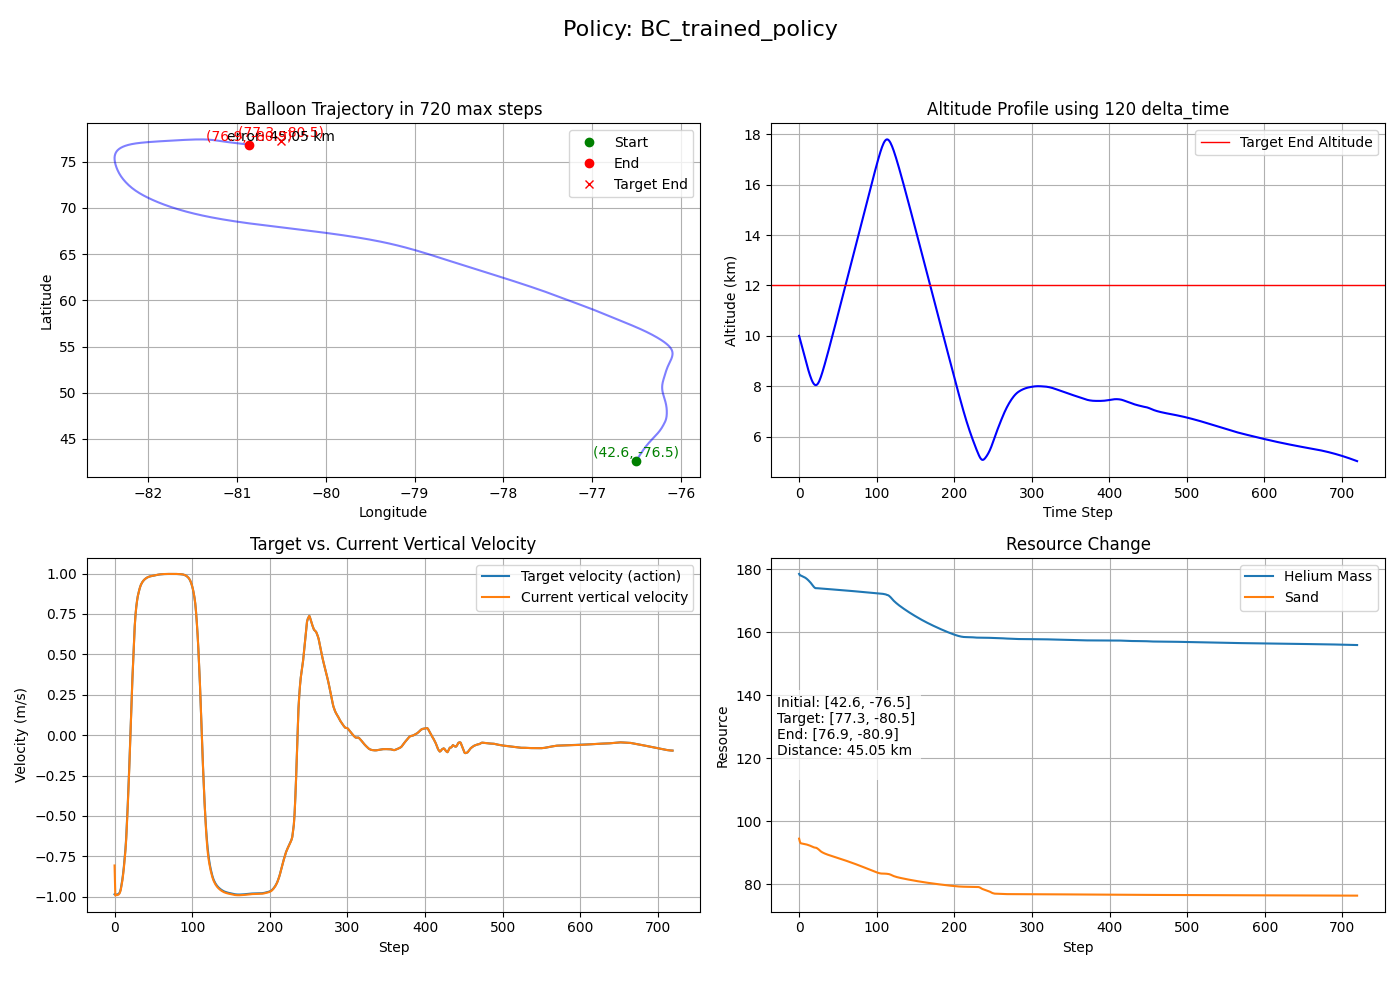

In [40]:
display(Image(filename=BC_trained_fnm))

## Save training data and trained network to your own Google Drive
- The saved model will be used in Imitation Learning.

In [28]:
folder_nm = expert_plot_fnms_list[0].split('/')[0] + '/' + expert_plot_fnms_list[0].split('/')[1]
print(folder_nm)

figs/target


In [29]:
## Save summary plots of expert and trained neural network.
import shutil

if not os.path.isdir('/content/drive/My Drive/Nb9/'+folder_nm):
    os.makedirs('/content/drive/My Drive/Nb9/'+folder_nm)

for path in expert_plot_fnms_list:
    shutil.copyfile('/content/balloon-outreach/'+path, '/content/drive/My Drive/Nb9/'+path)

shutil.copyfile('/content/balloon-outreach/'+BC_trained_fnm, '/content/drive/My Drive/Nb9/'+BC_trained_fnm)

'/content/drive/My Drive/Nb9/figs/target/balloon_summary_BC_trained_policy_(77.3,-80.5)_(77.1,-80.6)_err_11.70km.png'

In [30]:
## Expert trajectory and the summary

expert_data = {
    'expert_states_np' : expert_states_np,
    'expert_actions_np': expert_actions_np,
    'expert_plot_fnms_list' : expert_plot_fnms_list,
    'expert_total_reward_list' : expert_total_reward_list
}

In [31]:
## Save trained neural network

checkpoint = {
    'expert_data' : expert_data,
    'BC_trained_plot_fnm' : BC_trained_fnm,
    'model_state_dict' : policy.state_dict()
}

torch.save(checkpoint, '/content/drive/My Drive/Nb9/'+folder_nm+'/policy_checkpoint.pth')